# 8 Logistic Regression

In [1]:
import numpy

import scipy.special

import utils.project_module as pm
from utils.logger import Logger
import utils.plot as P

# restart kernel
import importlib
importlib.reload(pm)

# Initialize logger
logger = Logger("Logistic_Regression")


In [2]:
inputFile = './input/trainData.txt'

logIsActive = True
save_tables = True
save_model = True
save_plots = True

D, L = pm.load(inputFile)
(DTR, LTR), (DVAL, LVAL) = pm.split_db_2to1(D, L)

In [29]:
logger.__close__()

## Understand lab functions and requirements

### Function landscape

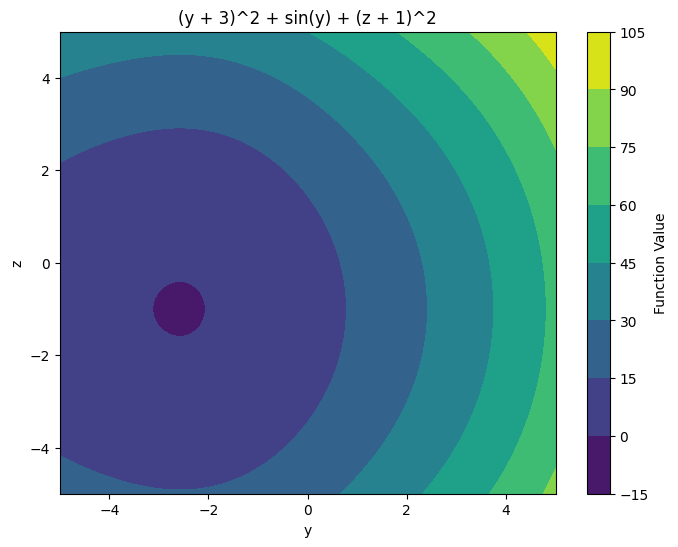

In [213]:
import matplotlib.pyplot as plt

def f(x):
	y, z = x
	return (y + 3)**2 + numpy.sin(y) + (z + 1)**2

y = numpy.linspace(-5, 5, 100)
z = numpy.linspace(-5, 5, 100)
x = numpy.array([y, z])

Y, Z = numpy.meshgrid(y, z)
X = numpy.array([Y, Z])
result = f(X)

plt.figure(figsize=(8, 6))
plt.contourf(Y, Z, result, cmap='viridis')
plt.colorbar(label='Function Value')
plt.xlabel('y')
plt.ylabel('z')
plt.title('(y + 3)^2 + sin(y) + (z + 1)^2')
plt.show()

### f(y, z) minimum finding (approx_grad)

In [214]:
x, f, d = scipy.optimize.fmin_l_bfgs_b(f, numpy.array([0, 0]), approx_grad = True, iprint = 1)

print(x)
print(f)
print(d)

[-2.57747138 -0.99999927]
-0.3561430123647649
{'grad': array([-1.49324998e-06,  1.46549439e-06]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 21, 'nit': 6, 'warnflag': 0}


### f(y, z) minimum finding

In [215]:
def f2(x):
	y, z = x
	f = (y + 3)**2 + numpy.sin(y) + (z + 1)**2
	grady = 2 * (y + 3) + numpy.cos(y)
	gradz = 2 * (z + 1)

	return f, numpy.array([grady, gradz])

x, f, d = scipy.optimize.fmin_l_bfgs_b(f2, numpy.array([0, 0]), iprint = 1)

print(x)
print(f)
print(d)

[-2.57747137 -0.99999927]
-0.3561430123647611
{'grad': array([-1.50318729e-06,  1.46120529e-06]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 7, 'nit': 6, 'warnflag': 0}


## Functions

In [3]:
# Optimize the logistic regression loss
def trainLogRegBinary(DTR, LTR, l):

    ZTR = LTR * 2.0 - 1.0 # We do it outside the objective function, since we only need to do it once

    def logreg_obj_with_grad(v): # We compute both the objective and its gradient to speed up the optimization
        w = v[:-1]
        b = v[-1]
        s = (pm.vcol(w).T @ DTR).ravel() + b

        loss = numpy.logaddexp(0, -ZTR * s)

        G = -ZTR / (1.0 + numpy.exp(ZTR * s))
        GW = (pm.vrow(G) * DTR).mean(1) + l * w.ravel()
        Gb = G.mean()
        return loss.mean() + l / 2 * numpy.linalg.norm(w)**2, numpy.hstack([GW, numpy.array(Gb)])

    vf = scipy.optimize.fmin_l_bfgs_b(logreg_obj_with_grad, x0 = numpy.zeros(DTR.shape[0]+1))[0]
    # print ("Log-reg - lambda = %e - J*(w, b) = %e" % (l, logreg_obj_with_grad(vf)[0]))
    return vf[:-1], vf[-1]

# Optimize the weighted logistic regression loss
def trainWeightedLogRegBinary(DTR, LTR, l, pT):

    ZTR = LTR * 2.0 - 1.0 # We do it outside the objective function, since we only need to do it once
    
    wTrue = pT / (ZTR>0).sum() # Compute the weights for the two classes
    wFalse = (1-pT) / (ZTR<0).sum()

    def logreg_obj_with_grad(v): # We compute both the objective and its gradient to speed up the optimization
        w = v[:-1]
        b = v[-1]
        s = numpy.dot(pm.vcol(w).T, DTR).ravel() + b

        loss = numpy.logaddexp(0, -ZTR * s)
        loss[ZTR>0] *= wTrue # Apply the weights to the loss computations
        loss[ZTR<0] *= wFalse

        G = -ZTR / (1.0 + numpy.exp(ZTR * s))
        G[ZTR > 0] *= wTrue # Apply the weights to the gradient computations
        G[ZTR < 0] *= wFalse
        
        GW = (pm.vrow(G) * DTR).sum(1) + l * w.ravel()
        Gb = G.sum()
        return loss.sum() + l / 2 * numpy.linalg.norm(w)**2, numpy.hstack([GW, numpy.array(Gb)])

    vf = scipy.optimize.fmin_l_bfgs_b(logreg_obj_with_grad, x0 = numpy.zeros(DTR.shape[0]+1))[0]
    #print ("Weighted Log-reg (pT %e) - lambda = %e - J*(w, b) = %e" % (pT, l, logreg_obj_with_grad(vf)[0]))
    return vf[:-1], vf[-1]


# def compute_logReg_DCF_vsLambdas(lambdas, DTR, LTR, DVAL, LVAL, prior=0.1, Cfn=1.0, Cfp=1.0, prior_weight=False, save_disk=False, output_dir='./outputs/models', output_name=None):
#     error_rates = []
#     actDCFs = []
#     minDCFs = []
#     parameters = []
#     for l in lambdas:
#         w, b = trainLogRegBinary(DTR, LTR, l) if not prior_weight else trainWeightedLogRegBinary(DTR, LTR, l, prior_weight)

#         if save_disk:
#             parameters.append({'lambda': l, 'parameters': numpy.hstack([w, b])})

#         sVal = w.T @ DVAL + b # Compute validation scores
#         PVAL = (sVal > 0) * 1 # Predict validation labels - sVal > 0 returns a boolean array, multiplying by 1 (integer) we get an integer array with 0's and 1's corresponding to the original True and False values
        
#         err = (PVAL != LVAL).sum() / float(LVAL.size)
#         #print ('Error rate: %.3f' % (err*100))
#         error_rates.append(err)

#         p = pEmp if not prior_weight else prior_weight
        
#         # DCF computing
#         sVal_llr = sVal - numpy.log(p / (1 - p))

#         actDCF = pm.compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sVal_llr, LVAL, prior, Cfn, Cfp)
#         minDCF = pm.compute_minDCF_binary_fast(sVal_llr, LVAL, prior, Cfn, Cfp, returnThreshold=False)

#         actDCFs.append(actDCF)
#         minDCFs.append(minDCF)
    
#     if save_disk:
        
#         numpy.save(f'./outputs/L8/models/{save_disk}', parameters)
    
#     return error_rates, actDCFs, minDCFs

In [218]:
# def plot_error_rates(lambdas, error_rates):
# 	plt.figure(figsize=(8, 6))
# 	plt.plot(lambdas, error_rates, marker='o', label='Error Rate')
# 	plt.xscale('log', base=10)
# 	plt.xlabel(r'$\lambda$')
# 	plt.ylabel('Error Rate')
# 	plt.title('Error Rate vs Regularization Parameter (Lambda)')
# 	plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# 	plt.legend()
# 	plt.tight_layout()
# 	plt.show()
  
# def setup_plot_DCFs(title=False):
# 	plt.figure(figsize=(10, 6))
# 	plt.xscale('log', base=10)
# 	plt.xlabel(r'$\lambda$', fontsize=12)
# 	plt.ylabel('DCF', fontsize=12)
# 	plt.title(f'actDCF and minDCF vs Regularization Parameter (Lambda){f' - {title}' if title else '' }', fontsize=14)
# 	plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# 	#plt.legend(fontsize=12)
# 	#plt.tight_layout()

# def plot_DCFs(lambdas, actDCFs, minDCFs, c1='r', c2='b', title=False):
# 	setup_plot_DCFs(title)
	
# 	plt.plot(lambdas, actDCFs, marker='o', label='actDCF', color=c1)
# 	plt.plot(lambdas, minDCFs, marker='o', label='minDCF', color=c2)
	
# 	plt.legend(fontsize=12)  # Aggiungi la legenda dopo aver plottato i dati
# 	plt.tight_layout()
# 	if(title):
# 		plt.savefig(f'./outputs/L8/{title.replace(' ', '_').replace(',', '')}.jpg')
# 		plt.savefig(f'./outputs/L8/{title.replace(' ', '_').replace(',', '')}.pdf')
# 	plt.show()

In [27]:
def update_logReg_DCF(LVAL, prior, scores, p, actDCFs, minDCFs, error_rates, TABLE, logIsActive=False, save_tables=False):
    predictions = (scores > 0) * 1      # Predict validation labels - sVal > 0 returns a boolean array, multiplying by 1 (integer) we get an integer array with 0's and 1's corresponding to the original True and False values
    err = (predictions != LVAL).sum() / float(LVAL.size)
    error_rates.append(err*100)

    # DCF computing
    s_llr = scores - numpy.log(p / (1 - p))

    actDCF = pm.compute_empirical_Bayes_risk_binary_llr_optimal_decisions(s_llr, LVAL, prior)
    minDCF = pm.compute_minDCF_binary_fast(s_llr, LVAL, prior, returnThreshold=False)
    actDCFs.append(actDCF)
    minDCFs.append(minDCF)

    if logIsActive:
        logger.info("TRAINING RESULTS")
        logger.log()
        logger.log(f"actDCF: {actDCF:.3} - minDCF: {minDCF:.3}")
        logger.log(f"Error Rate: {err*100}% - Accuracy: {(1-err)*100}%")
    
    if save_tables:
        TABLE.append(round(actDCF, 3))
        TABLE.append(round(minDCF, 3))
        TABLE.append(round(err*100, 2))
    
    return actDCFs, minDCFs, error_rates, TABLE

def log_train_results(actDCFs, minDCFs, error_rates):
    logger.log_separator()
    logger.log("All actDCF obtained:")
    logger.log(actDCFs)
    logger.log("All minDCF obtained:")
    logger.log(minDCFs)
    logger.log("All errors obtained:")
    logger.log(error_rates)

## Training

In [5]:
lambdas = numpy.logspace(-4, 2, 13)
prior, Cfn, Cfp = 0.1, 1.0, 1.0

pEmp = (LTR == 1).sum() / LTR.size

### Basic LogReg

In [ ]:
error_rates = []
actDCFs = []
minDCFs = []
parameters = []

TABLE = [ [l] for l in lambdas]
HEADER = [ "λ", "actDCF", "minDCF", "ERROR RATE (%)"]


if logIsActive:
    logger.log_title("Training Logistic Regression - Basic version")
    logger.log(f"lambdas = {lambdas.shape}")
    logger.log(lambdas.tolist())


for i, l in enumerate(lambdas):
    if logIsActive:
        logger.log_paragraph(f"{i+1}. Training basic LogReg with λ = {l}")
    
    w, b = trainLogRegBinary(DTR, LTR, l)
    sVal = w.T @ DVAL + b # Compute validation scores
    
    actDCFs, minDCFs, error_rates, TABLE[i] = update_logReg_DCF(LVAL, prior, sVal, pEmp, actDCFs, minDCFs, error_rates, TABLE[i], logIsActive, save_tables)
    if save_model:
        parameters.append({'lambda': l, 'parameters': numpy.hstack([w, b])})

if logIsActive:
    log_train_results(actDCFs, minDCFs, error_rates)
    
    logger.log_separator()
    logger.log("Logistic Regression training (basic version) completed!")

if save_model:        
    numpy.save(f'./outputs/L8/models/Basic.npy', parameters)

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, output_dir="./outputs/L8", output_file="LogReg_Basic")



#### Visual results

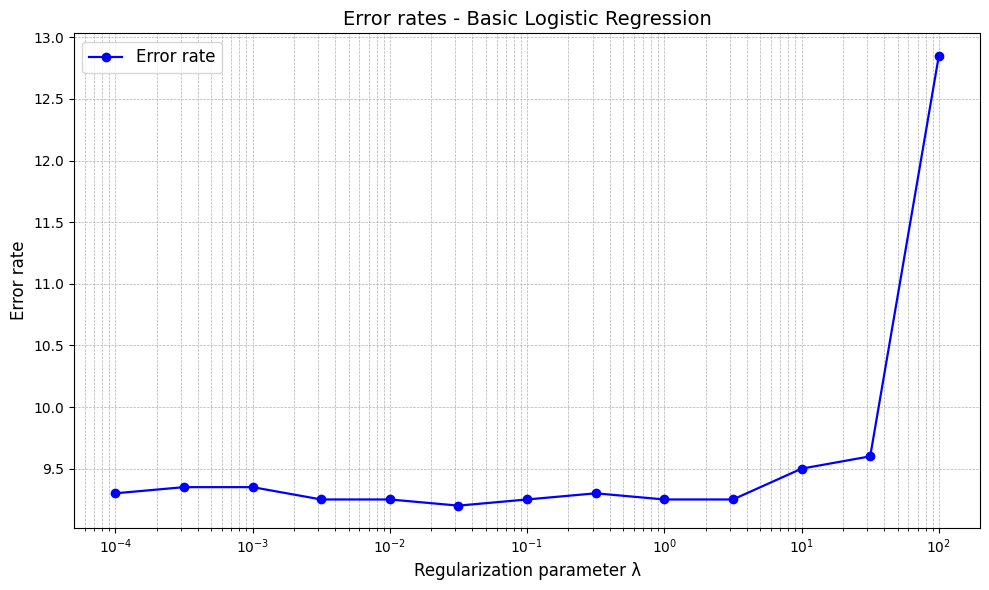

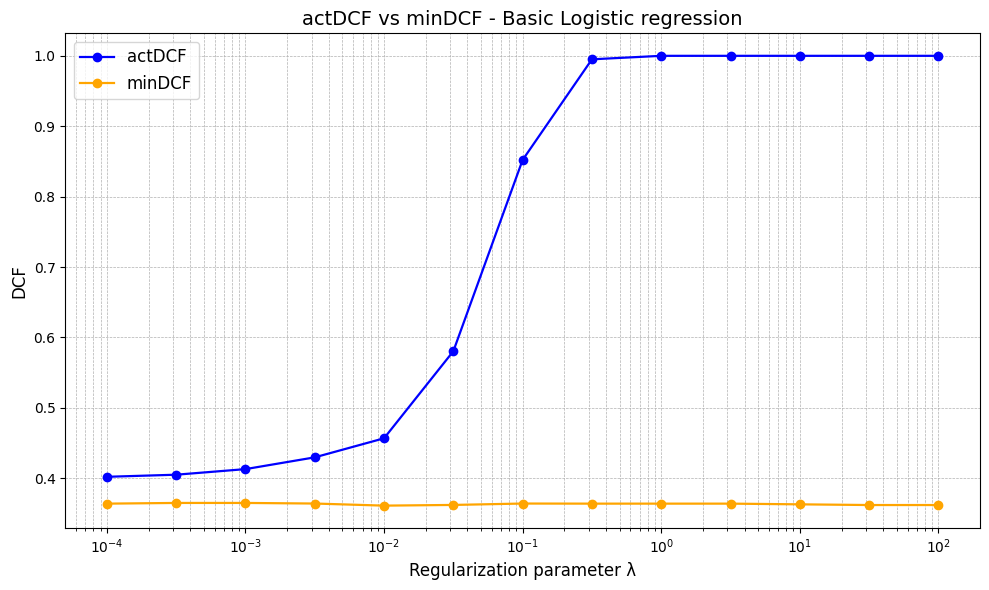

In [29]:
# Plot results
P.plot_log(lambdas, error_rates, title="Error rates - Basic Logistic Regression", xlabel=f"Regularization parameter λ", ylabel="Error rate", label0="Error rate", save_disk=save_plots, output_dir="./outputs/L8", output_name="ER_Basic_LogReg")
P.plot_log(lambdas, actDCFs, minDCFs, title="actDCF vs minDCF - Basic Logistic regression", xlabel=f"Regularization parameter λ", ylabel="DCF", label0="actDCF", label1="minDCF", save_disk=save_plots, output_dir="./outputs/L8", output_name="DCF_Basic_LogReg")

#### Check if model parameters are correctly saved

In [ ]:
params = numpy.load('./outputs/L8/models/Basic.npy', allow_pickle=True)
for p in params:
	print(p['lambda'])
	print(p['parameters'][:-1])
	print(p['parameters'][-1])
  

### Truncated LogReg

In [8]:
# Trunc the dataset to see the regularization term effect
DTR_trunc = DTR[:, ::50]
LTR_trunc = LTR[::50]

error_rates = []
actDCFs = []
minDCFs = []

TABLE = [ [l] for l in lambdas]
HEADER = [ "λ", "actDCF", "minDCF", "ERROR RATE (%)"]


if logIsActive:
    logger.log_title("Training Logistic Regression - Truncated dataset version")
    logger.log(f"lambdas = {lambdas.shape}")
    logger.log(lambdas.tolist())


for i, l in enumerate(lambdas):
    if logIsActive:
        logger.log_paragraph(f"{i+1}. Training truncated LogReg with λ = {l}")
    
    w, b = trainLogRegBinary(DTR_trunc, LTR_trunc, l)
    sVal = w.T @ DVAL + b # Compute validation scores
    
    actDCFs, minDCFs, error_rates, TABLE[i] = update_logReg_DCF(LVAL, prior, sVal, pEmp, actDCFs, minDCFs, error_rates, TABLE[i], logIsActive, save_tables)

if logIsActive:
    log_train_results(actDCFs, minDCFs, error_rates)
    
    logger.log_separator()
    logger.log("Logistic Regression training with truncated dataset completed!")

# if save_model:        
#     numpy.save(f'./outputs/L8/models/Truncated.npy', parameters)

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, output_dir="./outputs/L8", output_file="LogReg_Truncated")

#### Visual results

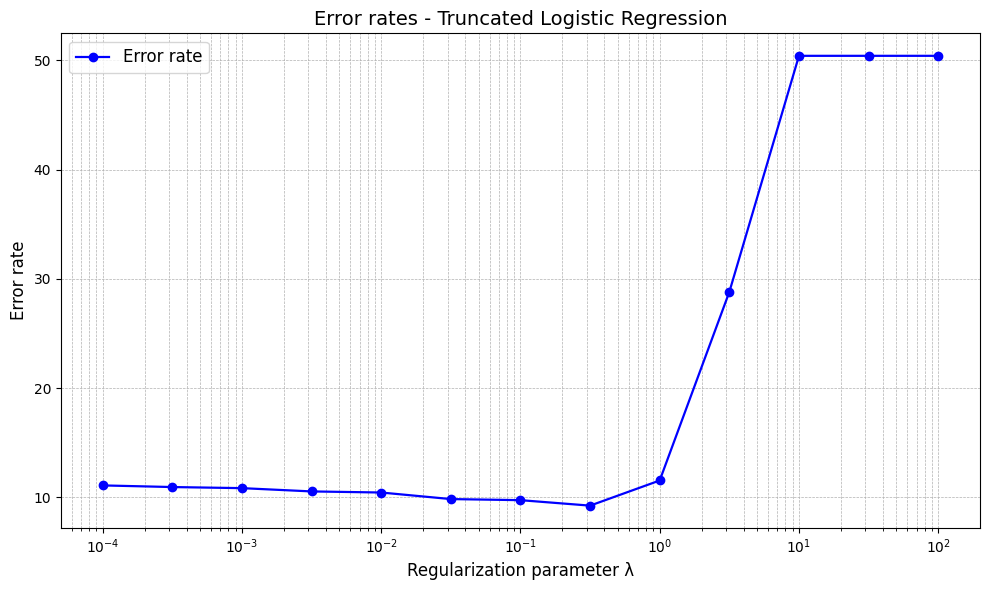

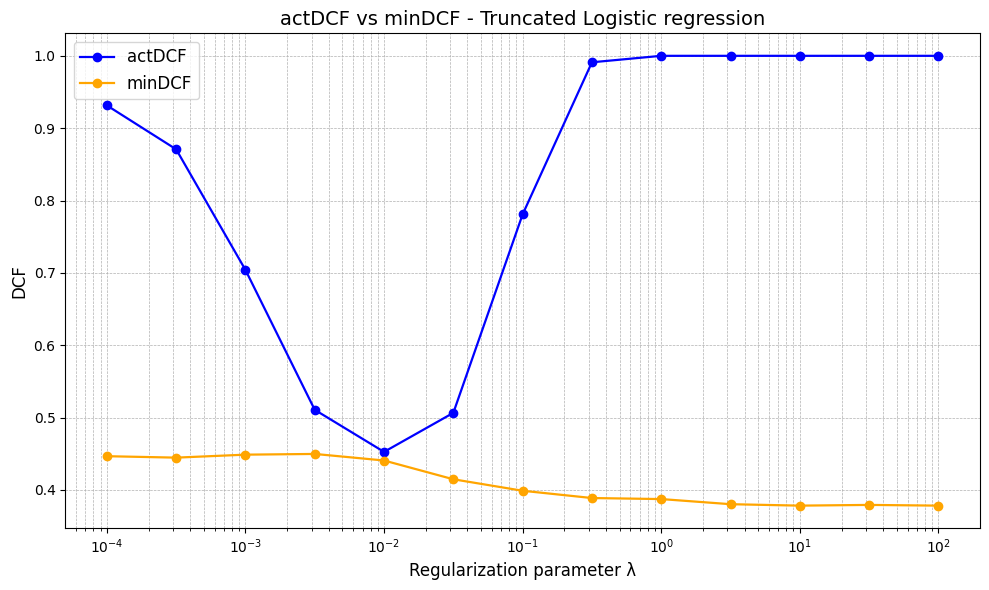

In [9]:
# Plot results
P.plot_log(lambdas, error_rates, title="Error rates - Truncated Logistic Regression", xlabel=f"Regularization parameter λ", ylabel="Error rate", label0="Error rate", save_disk=save_plots, output_dir="./outputs/L8", output_name="ER_Truncated_LogReg")
P.plot_log(lambdas, actDCFs, minDCFs, title="actDCF vs minDCF - Truncated Logistic regression", xlabel=f"Regularization parameter λ", ylabel="DCF", label0="actDCF", label1="minDCF", save_disk=save_plots, output_dir="./outputs/L8", output_name="DCF_Truncated_LogReg")

### Weighted LogReg

In [30]:
priors = numpy.linspace(0.1, 0.9, 9)

error_rates = [[] for _ in priors]
actDCFs = [[] for _ in priors]
minDCFs = [[] for _ in priors]
parameters = []

TABLE = [ [p, l] for p in priors for l in lambdas]
HEADER = [ "π", "λ", "actDCF", "minDCF", "ERROR RATE (%)"]


if logIsActive:
    logger.log_title("Training Logistic Regression - Weighted version")
    logger.log(f"lambdas = {lambdas.shape}")
    logger.log(lambdas.tolist())


for i, p in enumerate(priors):
	
    if logIsActive:
        logger.log_paragraph(f"{i+1}) Training weighted LogReg with π = {p}")
    
    for j, l in enumerate(lambdas):
        if logIsActive:
            logger.log_paragraph(f"{j+1}. λ = {l}")
        
        w, b = trainWeightedLogRegBinary(DTR, LTR, l, p)
        sVal = w.T @ DVAL + b # Compute validation scores
        
        actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(lambdas))+j] = update_logReg_DCF(LVAL, prior, sVal, p, actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(lambdas))+j], logIsActive, save_tables)

        if save_model:
            parameters.append({'lambda': l, 'parameters': numpy.hstack([w, b])})

    if logIsActive:
        log_train_results(actDCFs, minDCFs, error_rates)
     
    if save_model:        
        numpy.save(f'./outputs/L8/models/Weighted_P_0_{str(round(p,1)).replace('.','-')}.npy', parameters)

if logIsActive:
    logger.log_separator()
    logger.log("Logistic Regression training (weighted version) completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, output_dir="./outputs/L8", output_file="LogReg_Weighted")

#### Visual results

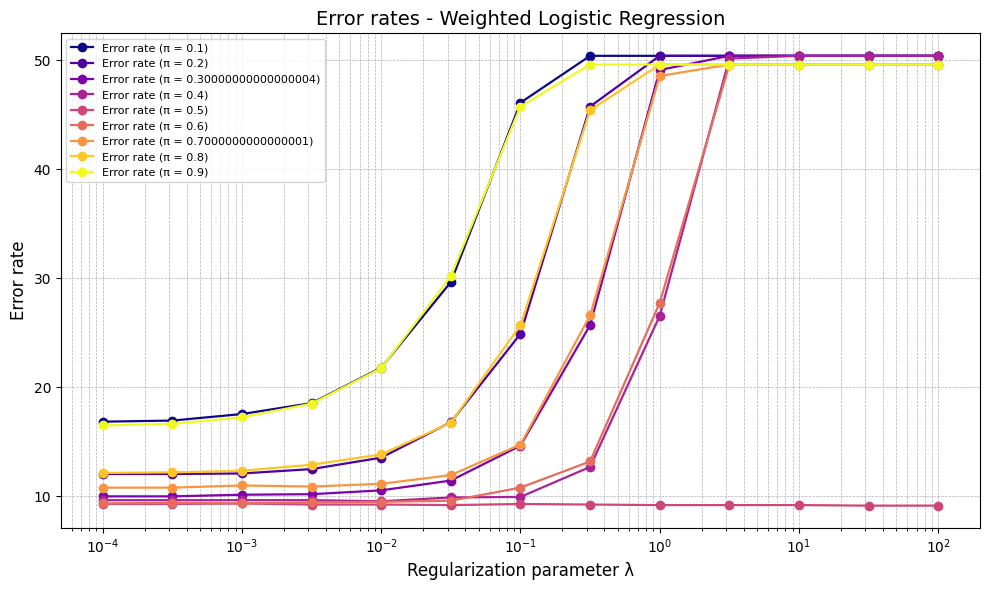

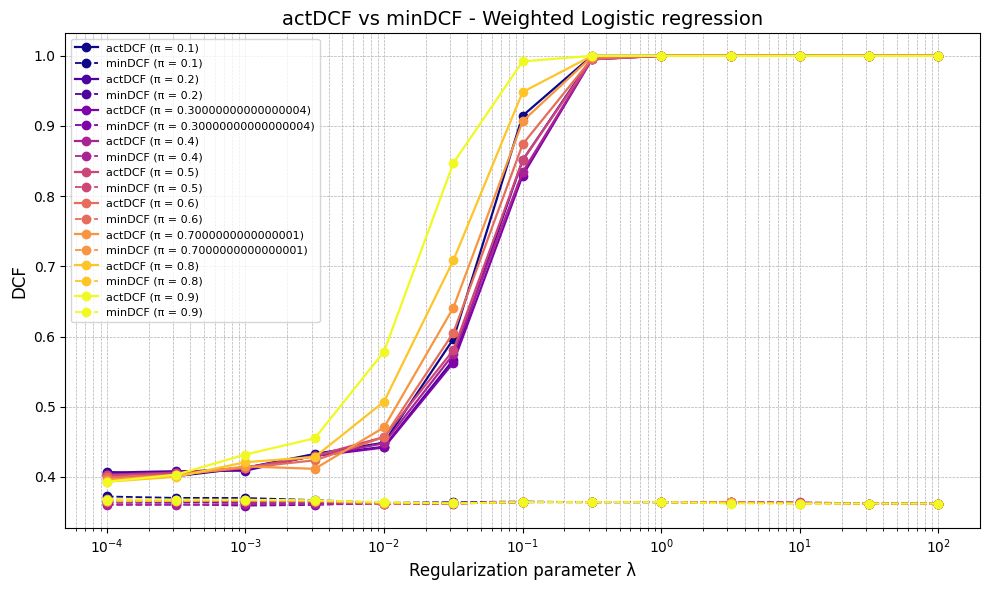

In [31]:
# Plot results
er_labels = [ f"Error rate (π = {p})" for p in priors]
labels0 = [ f"actDCF (π = {p})" for p in priors]
labels1 = [ f"minDCF (π = {p})" for p in priors]

P.plot_log(lambdas, error_rates, title="Error rates - Weighted Logistic Regression", xlabel=f"Regularization parameter λ", ylabel="Error rate", label0=er_labels, save_disk=save_plots, output_dir="./outputs/L8", output_name="ER_Weighted_LogReg")
P.plot_log(lambdas, actDCFs, minDCFs, title="actDCF vs minDCF - Weighted Logistic regression", xlabel=f"Regularization parameter λ", ylabel="DCF", label0=labels0, label1=labels1, save_disk=save_plots, output_dir="./outputs/L8", output_name="DCF_Weighted_LogReg")

### Quadratic LogReg

In [ ]:
def expand_features_quadratic(D):
	n_features, _ = D.shape
	expanded = [D]

	# Add squared terms
	expanded.append(D ** 2)

	# Add pairwise interaction terms
	for i in range(n_features):
		for j in range(i + 1, n_features):
			expanded.append(D[i, :] * D[j, :])

	return numpy.vstack(expanded)

DTR_expanded = expand_features_quadratic(DTR)
DVAL_expanded = expand_features_quadratic(DVAL)


error_rates = []
actDCFs = []
minDCFs = []
parameters = []

TABLE = [ [l] for l in lambdas]
HEADER = [ "λ", "actDCF", "minDCF", "ERROR RATE (%)"]


if logIsActive:
    logger.log_title("Training Logistic Regression - Quadratic version")
    logger.log(f"lambdas = {lambdas.shape}")
    logger.log(lambdas.tolist())


for i, l in enumerate(lambdas):
    if logIsActive:
        logger.log_paragraph(f"{i+1}. Training Quadratic LogReg with λ = {l}")
    
    w, b = trainLogRegBinary(DTR_expanded, LTR, l)
    sVal = w.T @ DVAL_expanded + b # Compute validation scores
    
    actDCFs, minDCFs, error_rates, TABLE[i] = update_logReg_DCF(LVAL, prior, sVal, pEmp, actDCFs, minDCFs, error_rates, TABLE[i], logIsActive, save_tables)

    if save_model:
        parameters.append({'lambda': l, 'parameters': numpy.hstack([w, b])})

if logIsActive:
    log_train_results(actDCFs, minDCFs, error_rates)
    
    logger.log_separator()
    logger.log("Logistic Regression training (quadratic version) completed!")

if save_model:        
    numpy.save(f'./outputs/L8/models/Quadratic.npy', parameters)

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, output_dir="./outputs/L8", output_file="LogReg_Quadratic")


#### Visual results

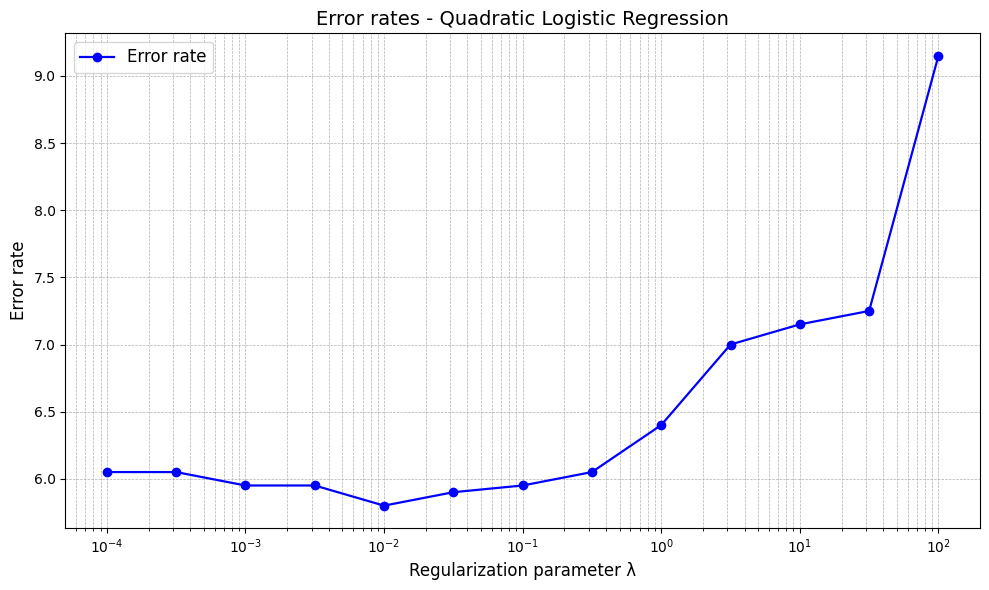

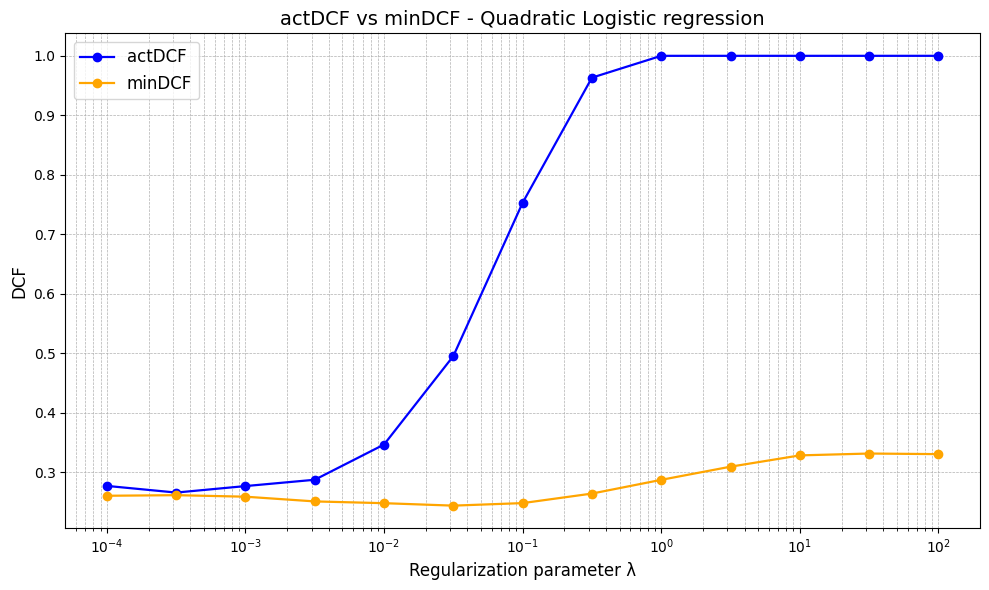

In [15]:
# Plot results
P.plot_log(lambdas, error_rates, title="Error rates - Quadratic Logistic Regression", xlabel=f"Regularization parameter λ", ylabel="Error rate", label0="Error rate", save_disk=save_plots, output_dir="./outputs/L8", output_name="ER_Quadratic_LogReg")
P.plot_log(lambdas, actDCFs, minDCFs, title="actDCF vs minDCF - Quadratic Logistic regression", xlabel=f"Regularization parameter λ", ylabel="DCF", label0="actDCF", label1="minDCF", save_disk=save_plots, output_dir="./outputs/L8", output_name="DCF_Quadratic_LogReg")

### Pre Processed data

#### Data centering and Z-normalizing

In [39]:
# PROJECT MODULE
def center_data(DTR, DVAL):
	mean = pm.vcol(DTR.mean(1))
	DTR_centered = DTR - mean
	DVAL_centered = DVAL - mean

	return DTR_centered, DVAL_centered

def Z_normalization(DTR, DVAL):
	std = pm.vcol(DTR.std(1))
	DTR_normalized = DTR / std
	DVAL_normalized = DVAL / std

	return DTR_normalized, DVAL_normalized


DTR_centered, DVAL_centered = center_data(DTR, DVAL)
DTR_normalized, DVAL_normalized = Z_normalization(DTR_centered, DVAL_centered)

DTR_list = [DTR_centered, DTR_normalized]
DVAL_list = [DVAL_centered, DVAL_normalized]
titles = ["Centered data", "Z-normalized data"]


error_rates = [ [] for _ in titles ]
actDCFs = [ [] for _ in titles ]
minDCFs = [ [] for _ in titles]

TABLE = [ [t, l] for t in titles for l in lambdas ]
HEADER = [ "Processing method", "λ", "actDCF", "minDCF", "ERROR RATE (%)"]


for i, t in enumerate(titles):

    if logIsActive:
        logger.log_title(f"Training Logistic Regression - {t}")
        logger.log(f"lambdas = {lambdas.shape}")
        logger.log(lambdas.tolist())


    for j, l in enumerate(lambdas):
        if logIsActive:
            logger.log_paragraph(f"{j+1}. Training LogReg ({t}) with λ = {l}")
        
        w, b = trainLogRegBinary(DTR_list[i], LTR, l)
        sVal = w.T @ DVAL_list[i] + b # Compute validation scores
        
        actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(lambdas)+j)] = update_logReg_DCF(LVAL, prior, sVal, pEmp, actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(lambdas)+j)], logIsActive, save_tables)

    if logIsActive:
        log_train_results(actDCFs, minDCFs, error_rates)
        
        logger.log_separator()
        logger.log(f"Logistic Regression training ({t}) completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, output_dir="./outputs/L8", output_file=f"LogReg_{t.split()[0]}")


##### Visual results

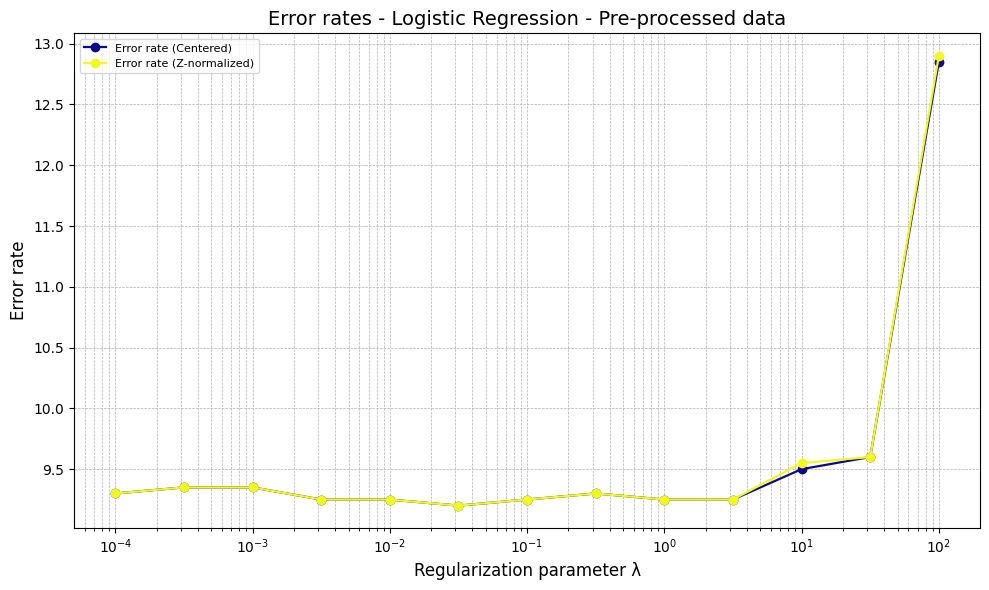

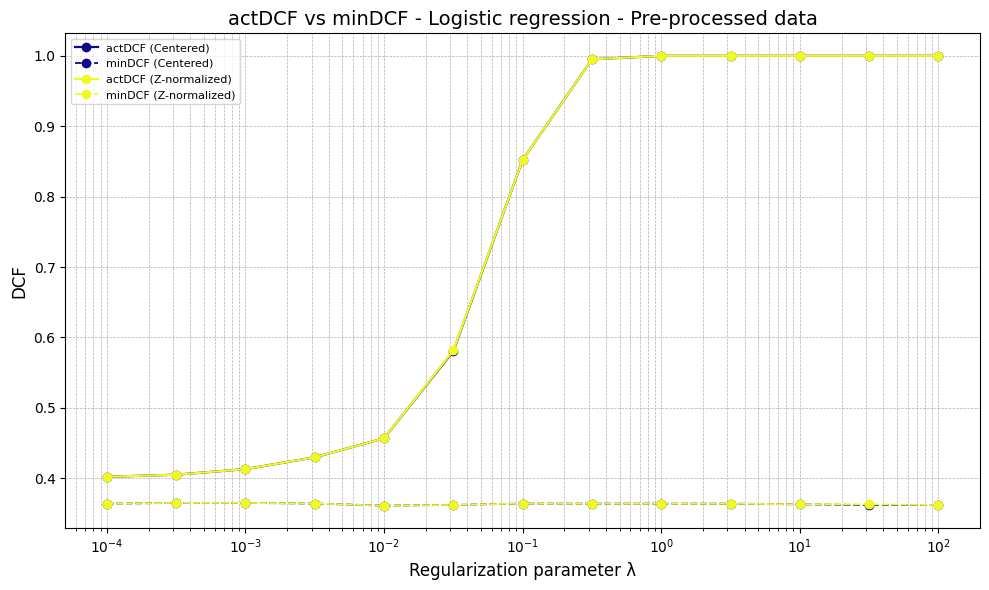

In [40]:
# Plot results
er_labels = [ f"Error rate ({t.split()[0]})" for t in titles]
labels0 = [ f"actDCF ({t.split()[0]})" for t in titles]
labels1 = [ f"minDCF ({t.split()[0]})" for t in titles]

P.plot_log(lambdas, error_rates, title="Error rates - Logistic Regression - Pre-processed data", xlabel=f"Regularization parameter λ", ylabel="Error rate", label0=er_labels, save_disk=save_plots, output_dir="./outputs/L8", output_name="ER_PreProcessed_LogReg")
P.plot_log(lambdas, actDCFs, minDCFs, title="actDCF vs minDCF - Logistic regression - Pre-processed data", xlabel=f"Regularization parameter λ", ylabel="DCF", label0=labels0, label1=labels1, save_disk=save_plots, output_dir="./outputs/L8", output_name="DCF_PreProcessed_LogReg")

#### PCA

In [42]:
DTR_pca = []
DVAL_pca = []

for m in range(6):
	UPCA = pm.compute_pca(DTR, m+1)
	DTR_pca.append(pm.apply_pca(UPCA, DTR))
	DVAL_pca.append(pm.apply_pca(UPCA, DVAL))
	

error_rates = [[] for _ in range(6)]
actDCFs = [[] for _ in range(6)]
minDCFs = [[] for _ in range(6)]
parameters = []

TABLE = [ [m+1, l] for m in range(6) for l in lambdas]
HEADER = [ "PCA directions (m)", "λ", "actDCF", "minDCF", "ERROR RATE (%)"]


if logIsActive:
    logger.log_title("Training Logistic Regression - PCA processing on data")
    logger.log(f"lambdas = {lambdas.shape}")
    logger.log(lambdas.tolist())


for i in range(6):
	
    if logIsActive:
        logger.log_paragraph(f"{i+1}) Training LogReg with m = {i+1} PCA directions")
    
    for j, l in enumerate(lambdas):
        if logIsActive:
            logger.log_paragraph(f"{j+1}. λ = {l}")
        
        w, b = trainWeightedLogRegBinary(DTR_pca[i], LTR, l, pEmp)
        sVal = w.T @ DVAL_pca[i] + b # Compute validation scores
        
        actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(lambdas))+j] = update_logReg_DCF(LVAL, prior, sVal, p, actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(lambdas))+j], logIsActive, save_tables)

        if save_model:
            parameters.append({'lambda': l, 'parameters': numpy.hstack([w, b])})

    if logIsActive:
        log_train_results(actDCFs, minDCFs, error_rates)

if logIsActive:
    logger.log_separator()
    logger.log("Logistic Regression training (PCA processing on data) completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, output_dir="./outputs/L8", output_file="LogReg_PCA")

##### Visual results

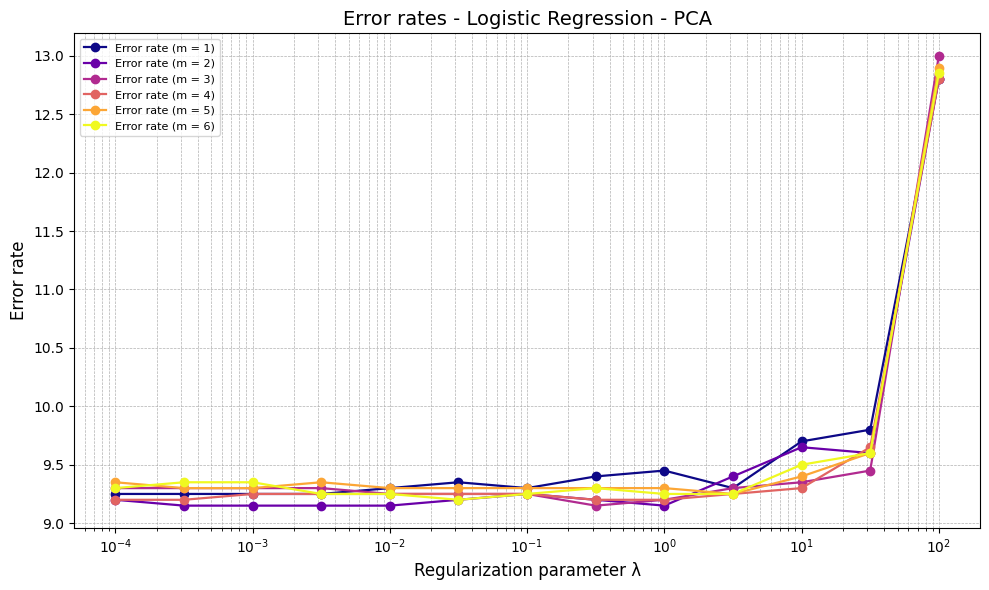

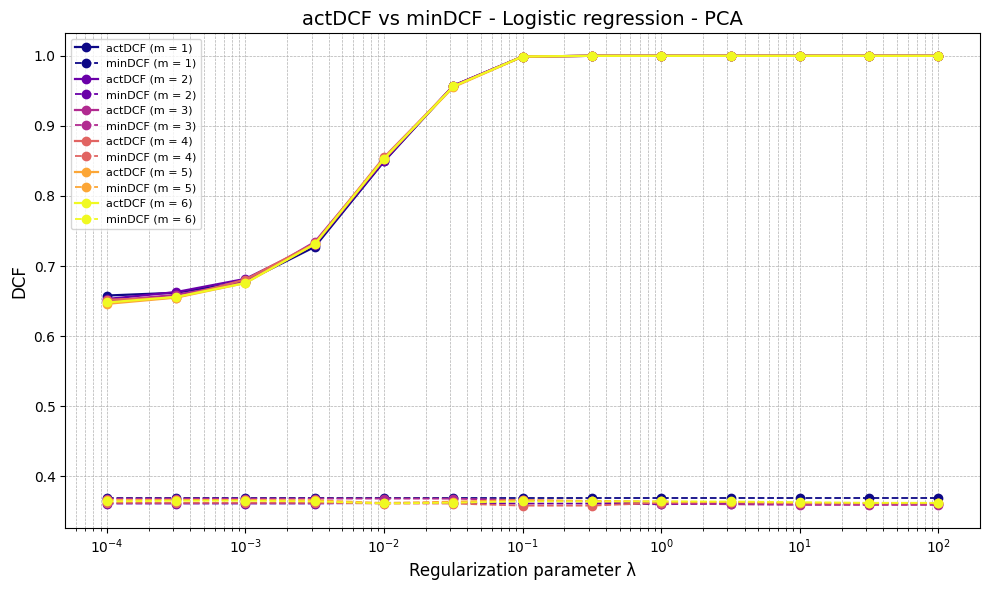

In [43]:
# Plot results
er_labels = [ f"Error rate (m = {m+1})" for m in range(6)]
labels0 = [ f"actDCF (m = {m+1})" for m in range(6)]
labels1 = [ f"minDCF (m = {m+1})" for m in range(6)]

P.plot_log(lambdas, error_rates, title="Error rates - Logistic Regression - PCA", xlabel=f"Regularization parameter λ", ylabel="Error rate", label0=er_labels, save_disk=save_plots, output_dir="./outputs/L8", output_name="ER_PCA_LogReg")
P.plot_log(lambdas, actDCFs, minDCFs, title="actDCF vs minDCF - Logistic regression - PCA", xlabel=f"Regularization parameter λ", ylabel="DCF", label0=labels0, label1=labels1, save_disk=save_plots, output_dir="./outputs/L8", output_name="DCF_PCA_LogReg")